<a href="https://colab.research.google.com/github/Sina-Khajehzadeh/TabPFN/blob/main/notebooks/tabular_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, torch
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
try:
    torch.set_num_threads(1)
except:
    pass

In [ ]:
!nvidia-smi
!pip -q install --upgrade pip
!pip -q install "torch>=2.3,<3.0" "torchvision>=0.18,<1.0" "torchaudio>=2.3,<3.0" --index-url https://download.pytorch.org/whl/cu121
!pip -q install tabpfn scikit-learn pandas numpy matplotlib joblib

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device, "| GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Fri Oct 10 09:59:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tabpfn, pkgutil
print("tabpfn version:", getattr(tabpfn, "__version__", "unknown"))
print("subpackages under tabpfn:", [m.name for m in pkgutil.iter_modules(tabpfn.__path__)])

tabpfn version: 2.2.1
subpackages under tabpfn: ['architectures', 'base', 'classifier', 'config', 'constants', 'finetune_utils', 'inference', 'model', 'model_loading', 'parallel_execute', 'preprocessing', 'preprocessors', 'regressor', 'settings', 'utils']


In [ ]:
import tabpfn
from tabpfn.classifier import TabPFNClassifier
from inspect import signature
import torch

print("tabpfn version:", getattr(tabpfn, "__version__", "unknown"))
print("device in use:", "cuda" if torch.cuda.is_available() else "cpu")
print("Device available:", "cuda" if torch.cuda.is_available() else "cpu")
print("TabPFNClassifier init parameters:")
print(signature(TabPFNClassifier.__init__))

tabpfn version: 2.2.1
device in use: cuda
Device available: cuda
TabPFNClassifier init parameters:
(self, *, n_estimators: 'int' = 8, categorical_features_indices: 'Sequence[int] | None' = None, softmax_temperature: 'float' = 0.9, balance_probabilities: 'bool' = False, average_before_softmax: 'bool' = False, model_path: "str | Path | Literal['auto']" = 'auto', device: 'DevicesSpecification' = 'auto', ignore_pretraining_limits: 'bool' = False, inference_precision: "_dtype | Literal['autocast', 'auto']" = 'auto', fit_mode: "Literal['low_memory', 'fit_preprocessors', 'fit_with_cache', 'batched']" = 'fit_preprocessors', memory_saving_mode: "bool | Literal['auto'] | float | int" = 'auto', random_state: 'int | np.random.RandomState | np.random.Generator | None' = 0, n_jobs: 'int' = -1, inference_config: 'dict | ModelInterfaceConfig | None' = None, differentiable_input: 'bool' = False) -> 'None'


In [ ]:
from tabpfn.classifier import TabPFNClassifier
import torch

clf = TabPFNClassifier(
    n_estimators=4,                                  # match mlr3 default
    device='cuda' if torch.cuda.is_available() else 'cpu',
    inference_precision='auto',                      # or 'autocast' to save VRAM
    n_jobs=1                                         # mirror mlr3 stability note
)
clf

TabPFNClassifier(device='cuda', n_estimators=4, n_jobs=1)

In [9]:
### Implementing model on the "AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections" Dataset
## Link address: https://www.physionet.org/content/antimicrobial-resistance-uti/1.0.0/
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/LMU-TAbPFN/amr_uti_merged (1).csv")

In [42]:
len(df)

116902

In [23]:
#### Choosing the target and modeling subset
import pandas as pd

TARGET = "NIT"  # change to SXT/CIP/LVX to run other models

use = df[(df["uncomplicated"] == 1) & (df[TARGET].notna())].copy()
print("Number of rows:", len(use))

Number of rows: 15806


In [41]:
df.columns

Index(['example_id', 'demographics - age', 'demographics - is_white',
       'demographics - is_veteran', 'micro - prev resistance LVX 14',
       'micro - prev resistance AMP 14', 'micro - prev resistance CFZ 14',
       'micro - prev resistance NIT 14', 'micro - prev resistance GEN 14',
       'micro - prev resistance SXT 14',
       ...
       'selected micro - colonization pressure SXT 90 - overall',
       'selected micro - colonization pressure TET 90 - overall',
       'selected micro - colonization pressure TZP 90 - overall',
       'selected micro - colonization pressure VAN 90 - overall', 'is_train',
       'uncomplicated', 'NIT', 'SXT', 'CIP', 'LVX'],
      dtype='object', length=795)

**Defining the Models**

In [11]:
# --- STEP 2: Define feature columns and labels (keep X as DataFrame) ---
import pandas as pd  # import pandas for DataFrame operations

meta_cols  = ["example_id", "is_train", "uncomplicated", "prescription"]  # not model features
label_cols = ["NIT", "SXT", "CIP", "LVX"]  # targets (we drop these from X)

feat_cols = [c for c in use.columns if c not in meta_cols + label_cols]  # select only feature columns

X = use[feat_cols].select_dtypes(include=["number"]).astype("float32")  # numeric features as float32
y = use[TARGET].astype(int)  # binary target for the chosen antibiotic (e.g., NIT)


# --- STEP 3: Drop any known leak features + simple imputation ---
leak_cols = ["temp_c_reference", "temp_c_temporal"]  # example potential leak columns (drop if present)
X_noleak = X.drop(columns=[c for c in leak_cols if c in X.columns], errors="ignore")  # drop leaks safely
X_noleak = X_noleak.fillna(0.0)  # replace missing values with 0.0 (simple and works across models)


# --- STEP 4: Group-aware split into train/test (avoid same patient in both) ---
from sklearn.model_selection import GroupShuffleSplit  # import group-aware splitter

groups = use["unique_subject_id"] if "unique_subject_id" in use.columns else use["example_id"]  # grouping key
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)  # 75/25 split at group level
train_idx, test_idx = next(gss.split(X_noleak, y, groups=groups))  # compute indices for train/test

Xtr, Xte = X_noleak.iloc[train_idx], X_noleak.iloc[test_idx]  # slice training and test features
ytr, yte = y.iloc[train_idx], y.iloc[test_idx]  # slice training and test labels


# --- STEP 5: Define the three model runners (LogReg, XGBoost, TabPFN) ---
from sklearn.linear_model import LogisticRegression  # linear baseline
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, mean_squared_error  # evaluation metrics
from xgboost import XGBClassifier  # strong tabular tree baseline
import torch, numpy as np  # TabPFN needs torch; numpy for arrays
from tabpfn.classifier import TabPFNClassifier  # TabPFN classifier

def run_logistic_regression(X_train, X_test, y_train, y_test):  # train + evaluate logistic regression
    lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')  # handle imbalance
    lr.fit(X_train, y_train)  # fit model
    pred = lr.predict(X_test)  # class predictions
    proba = lr.predict_proba(X_test)[:, 1]  # probability of class 1
    return (balanced_accuracy_score(y_test, pred),  # balanced accuracy
            roc_auc_score(y_test, proba),           # AUROC
            mean_squared_error(y_test, pred))       # MSE on hard predictions

def run_xgboost(X_train, X_test, y_train, y_test):  # train + evaluate XGBoost
    posw = (len(y_train) - y_train.sum()) / max(1, y_train.sum())  # weight positives for imbalance
    xgb = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,  # small, fast model
                        eval_metric='logloss', scale_pos_weight=posw, n_jobs=1,
                        tree_method='hist')  # efficient histogram tree builder
    xgb.fit(X_train, y_train)  # fit model
    pred = xgb.predict(X_test)  # class predictions
    proba = xgb.predict_proba(X_test)[:, 1]  # probability of class 1
    return (balanced_accuracy_score(y_test, pred),  # balanced accuracy
            roc_auc_score(y_test, proba),           # AUROC
            mean_squared_error(y_test, pred))       # MSE

def run_tabpfn(X_train, X_test, y_train, y_test):  # train + evaluate TabPFN
    clf = TabPFNClassifier(n_estimators=4,  # small ensemble of pretrained transformers
                           device='cuda' if torch.cuda.is_available() else 'cpu',  # use GPU if present
                           inference_precision='auto', n_jobs=1,
                           ignore_pretraining_limits=True)  # allow larger N than default
    clf.fit(X_train.values, y_train.values)  # TabPFN expects numpy arrays
    pred = clf.predict(X_test.values)  # class predictions
    proba = clf.predict_proba(X_test.values)[:, 1]  # probability of class 1
    return (balanced_accuracy_score(y_test, pred),  # balanced accuracy
            roc_auc_score(y_test, proba),           # AUROC
            mean_squared_error(y_test, pred))       # MSE


# --- STEP 6: Train all three models and print metrics ---
m_lr  = run_logistic_regression(Xtr, Xte, ytr, yte)  # run Logistic Regression
m_xgb = run_xgboost(Xtr, Xte, ytr, yte)              # run XGBoost
m_tab = run_tabpfn(Xtr, Xte, ytr, yte)               # run TabPFN

print(f"{TARGET} — LogReg  (BA, AUROC, MSE):", m_lr)   # show metrics for Logistic Regression
print(f"{TARGET} — XGBoost (BA, AUROC, MSE):", m_xgb)  # show metrics for XGBoost
print(f"{TARGET} — TabPFN  (BA, AUROC, MSE):", m_tab)  # show metrics for TabPFN

NIT — LogReg  (BA, AUROC, MSE): (np.float64(0.5318230852211435), np.float64(0.5325978805761786), 0.35779352226720645)
NIT — XGBoost (BA, AUROC, MSE): (np.float64(0.5674110032362459), np.float64(0.5806440764007867), 0.3084514170040486)
NIT — TabPFN  (BA, AUROC, MSE): (np.float64(0.5076350022209531), np.float64(0.5575322038200393), 0.11234817813765183)


**Simulation with 10 iterations**

In [ ]:
import numpy as np, matplotlib.pyplot as plt, warnings
from timeit import default_timer as timer
from sklearn.model_selection import GroupShuffleSplit
warnings.filterwarnings('ignore')

# --- groups aligned to X/y (prevents patient leakage) ---
groups_all = (use.loc[X_noleak.index, "unique_subject_id"]
              if "unique_subject_id" in use.columns
              else use.loc[X_noleak.index, "example_id"])

# --- TabPFN adapter: cap cols/rows, then call your run_tabpfn ---
def _tabpfn_adapter(X_tr, X_te, y_tr, y_te, max_rows=1000, max_cols=200, n_estimators=1):
    # limit columns by variance
    if X_tr.shape[1] > max_cols:
        keep = X_tr.var().sort_values(ascending=False).index[:max_cols]
        X_tr2, X_te2 = X_tr[keep], X_te[keep]
    else:
        X_tr2, X_te2 = X_tr, X_te
    # stratified subsample rows if too many (CPU-safe)
    if len(X_tr2) > max_rows:
        pos = y_tr[y_tr==1].index.to_numpy(); neg = y_tr[y_tr==0].index.to_numpy()
        p = len(pos)/len(y_tr); n_pos = max(1, int(round(max_rows*p))); n_neg = max_rows - n_pos
        sel_pos = np.random.choice(pos, min(n_pos,len(pos)), replace=False)
        sel_neg = np.random.choice(neg, min(n_neg,len(neg)), replace=False)
        idx = np.concatenate([sel_pos, sel_neg])
        X_tr2, y_tr2 = X_tr2.loc[idx], y_tr.loc[idx]
    else:
        y_tr2 = y_tr
    # call your existing TabPFN runner
    return run_tabpfn(X_tr2, X_te2, y_tr2, y_te)

def _unpack(m):
    # expect (BA, AUROC, MSE)
    return m if isinstance(m, (tuple,list)) and len(m)==3 else (None,None,float(m))

def simulate_models_grouped(X, y, groups, iterations=10, test_size=0.7,
                            tabpfn_params=dict(max_rows=1000, max_cols=200, n_estimators=1)):
    tab_ba, tab_auc, tab_mse, t_tab = [], [], [], []
    lr_ba,  lr_auc,  lr_mse,  t_lr  = [], [], [], []
    xg_ba,  xg_auc,  xg_mse,  t_xgb = [], [], [], []
    wall = timer()

    for _ in range(iterations):
        # fresh random GROUPED split each time (no seed); avoids patient leakage
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=None)
        tr_idx, te_idx = next(gss.split(X, y, groups=groups))
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        if len(np.unique(y_te)) < 2:  # skip if test fold is single-class (rare)
            continue

        t0 = timer(); m_tab = _tabpfn_adapter(X_tr, X_te, y_tr, y_te, **tabpfn_params); t_tab.append(timer()-t0)
        t0 = timer(); m_lr  = run_logistic_regression(X_tr, X_te, y_tr, y_te);                   t_lr.append(timer()-t0)
        t0 = timer(); m_xgb = run_xgboost(X_tr, X_te, y_tr, y_te);                               t_xgb.append(timer()-t0)

        ba,auc,mse = _unpack(m_tab); tab_ba.append(ba); tab_auc.append(auc); tab_mse.append(mse)
        ba,auc,mse = _unpack(m_lr);  lr_ba.append(ba);  lr_auc.append(auc);  lr_mse.append(mse)
        ba,auc,mse = _unpack(m_xgb); xg_ba.append(ba);  xg_auc.append(auc);  xg_mse.append(mse)

    # summary (means)
    print(f"Completed {len(tab_mse)} iterations | test_size={test_size}")
    print(f"TabPFN  — BA {np.nanmean(tab_ba):.4f} | AUROC {np.nanmean(tab_auc):.4f} | MSE {np.mean(tab_mse):.6f} | sec/run {np.mean(t_tab):.2f}")
    print(f"LogReg  — BA {np.nanmean(lr_ba):.4f} | AUROC {np.nanmean(lr_auc):.4f} | MSE {np.mean(lr_mse):.6f} | sec/run {np.mean(t_lr):.2f}")
    print(f"XGBoost — BA {np.nanmean(xg_ba):.4f} | AUROC {np.nanmean(xg_auc):.4f} | MSE {np.mean(xg_mse):.6f} | sec/run {np.mean(t_xgb):.2f}")
    print(f"Total wall-clock: {timer()-wall:.2f}s")

    # optional AUROC boxplot
    plt.figure(figsize=(7,5))
    plt.boxplot([tab_auc, lr_auc, xg_auc], labels=['TabPFN','Logistic','XGBoost'])
    plt.ylabel('AUROC'); plt.title('AUROC across iterations (grouped splits)')
    plt.grid(True, ls='--', alpha=.5); plt.show()

    return {
        'TabPFN': {'BA':tab_ba,'AUROC':tab_auc,'MSE':tab_mse,'time':t_tab},
        'Logistic': {'BA':lr_ba,'AUROC':lr_auc,'MSE':lr_mse,'time':t_lr},
        'XGBoost': {'BA':xg_ba,'AUROC':xg_auc,'MSE':xg_mse,'time':t_xgb},
    }

# === run it (uses your prepared X_noleak, y) ===
results = simulate_models_grouped(
    X_noleak, y, groups_all,
    iterations=10, test_size=0.7,
    tabpfn_params=dict(max_rows=1000, max_cols=200, n_estimators=1)
)

**Running 10 iterations and Results MSE and ROC plots**

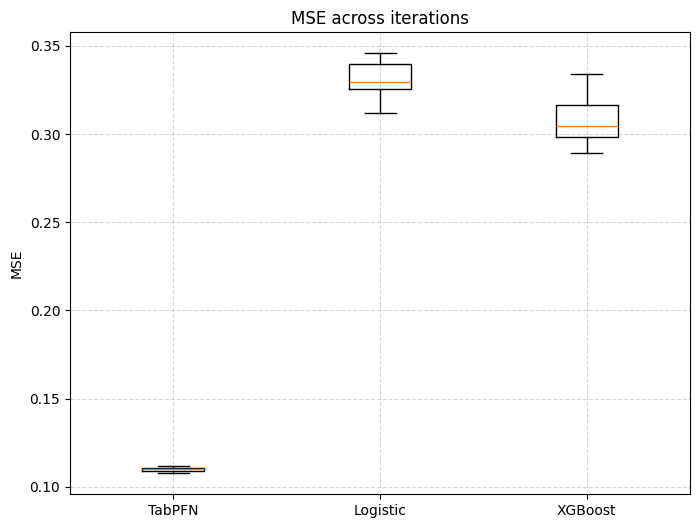

In [34]:
### Plotting the MSE Across Iterations
import matplotlib.pyplot as plt, numpy as np
res_log = results['Logistic'] if 'Logistic' in results else results['Logistic Regression']
plt.figure(figsize=(8,6))
plt.boxplot([results['TabPFN']['MSE'], res_log['MSE'], results['XGBoost']['MSE']],
            labels=['TabPFN','Logistic','XGBoost'])
plt.ylabel('MSE'); plt.title('MSE across iterations'); plt.grid(True, ls='--', alpha=.5); plt.show()

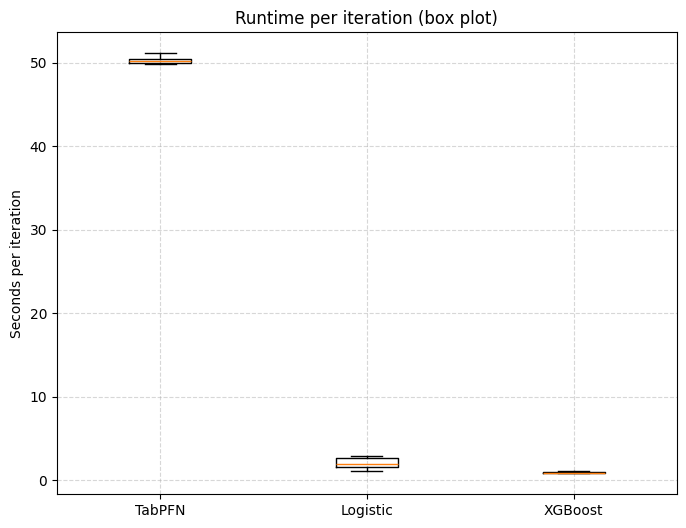

In [40]:
## Plotting the Run time

import matplotlib.pyplot as plt, numpy as np
res_log = results['Logistic'] if 'Logistic' in results else results['Logistic Regression']

plt.figure(figsize=(8,6))
plt.boxplot([results['TabPFN']['time'], res_log['time'], results['XGBoost']['time']],
            labels=['TabPFN','Logistic','XGBoost'], showfliers=False)
plt.ylabel('Seconds per iteration')
plt.title('Runtime per iteration (box plot)')
plt.grid(True, ls='--', alpha=.5)
# plt.yscale('log')  # <- optional if runtimes are skewed
plt.show()

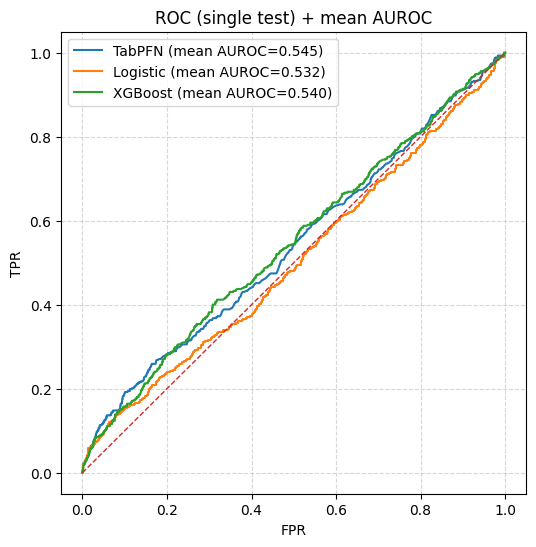

In [37]:
import numpy as np, matplotlib.pyplot as plt
res_log = results['Logistic'] if 'Logistic' in results else results['Logistic Regression']
m_tab, m_lr, m_xg = np.mean(results['TabPFN']['AUROC']), np.mean(res_log['AUROC']), np.mean(results['XGBoost']['AUROC'])

plt.figure(figsize=(6,6))
plt.plot(fpr_tab, tpr_tab, label=f"TabPFN (mean AUROC={m_tab:.3f})")
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic (mean AUROC={m_lr:.3f})")
plt.plot(fpr_xg,  tpr_xg,  label=f"XGBoost (mean AUROC={m_xg:.3f})")
plt.plot([0,1],[0,1],'--',lw=1); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (single test) + mean AUROC")
plt.legend(); plt.grid(True, ls="--", alpha=.5); plt.show()

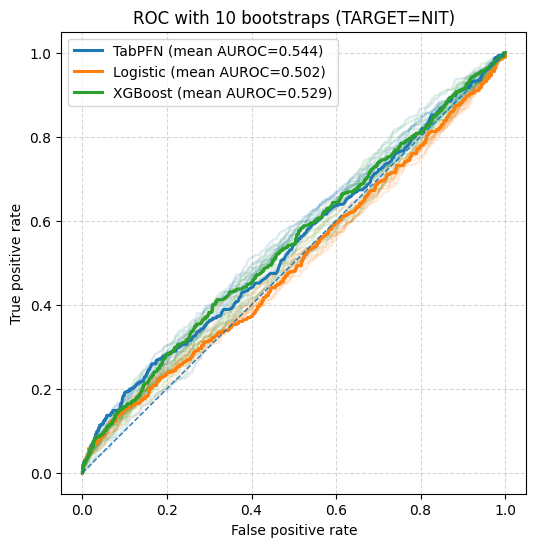

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np, matplotlib.pyplot as plt

iters = 10
rocL, rocX, rocT = [], [], []
auL,  auX,  auT  = [], [], []

# --- 10 bootstraps on the TRAIN set; fixed official TEST set ---
pos_idx = ytr[ytr==1].index.to_numpy()
neg_idx = ytr[ytr==0].index.to_numpy()

for _ in range(iters):
    # stratified bootstrap of the train set
    boot_idx = np.concatenate([
        np.random.choice(pos_idx, len(pos_idx), replace=True),
        np.random.choice(neg_idx, len(neg_idx), replace=True)
    ])
    Xb, yb = Xtr.loc[boot_idx], ytr.loc[boot_idx]

    # Logistic
    lr_b = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs").fit(Xb, yb)
    pro = lr_b.predict_proba(Xte)[:,1]; auL.append(roc_auc_score(yte, pro))
    fpr, tpr, _ = roc_curve(yte, pro); rocL.append((fpr, tpr))

    # XGBoost
    posw = (len(yb)-yb.sum())/max(1,yb.sum())
    xgb_b = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                          eval_metric="logloss", scale_pos_weight=posw, n_jobs=1, tree_method="hist").fit(Xb, yb)
    pro = xgb_b.predict_proba(Xte)[:,1]; auX.append(roc_auc_score(yte, pro))
    fpr, tpr, _ = roc_curve(yte, pro); rocX.append((fpr, tpr))

    # TabPFN (CPU-safe via your helper)
    pro = tabpfn_proba(Xb, Xte, yb); auT.append(roc_auc_score(yte, pro))
    fpr, tpr, _ = roc_curve(yte, pro); rocT.append((fpr, tpr))

# Bold ROC from full train set (you already computed pro_lr/pro_xg/pro_tab above)
# If not, compute quickly again:
# (reuses your configs)
lr_full  = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs").fit(Xtr, ytr)
pro_lr   = lr_full.predict_proba(Xte)[:,1]
posw     = (len(ytr)-ytr.sum())/max(1,ytr.sum())
xgb_full = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                         eval_metric="logloss", scale_pos_weight=posw, n_jobs=1, tree_method="hist").fit(Xtr, ytr)
pro_xg   = xgb_full.predict_proba(Xte)[:,1]
pro_tab  = tabpfn_proba(Xtr, Xte, ytr)

fpr_lr,  tpr_lr,  _ = roc_curve(yte, pro_lr)
fpr_xg,  tpr_xg,  _ = roc_curve(yte, pro_xg)
fpr_tab, tpr_tab, _ = roc_curve(yte, pro_tab)

# --- Plot: 10 faint curves + bold curve with MEAN AUROC ---
plt.figure(figsize=(6,6))

for fpr,tpr in rocT: plt.plot(fpr,tpr, alpha=0.15, color='C0')
for fpr,tpr in rocL: plt.plot(fpr,tpr, alpha=0.15, color='C1')
for fpr,tpr in rocX: plt.plot(fpr,tpr, alpha=0.15, color='C2')

plt.plot(fpr_tab, tpr_tab, label=f"TabPFN (mean AUROC={np.mean(auT):.3f})",  linewidth=2.2, color='C0')
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic (mean AUROC={np.mean(auL):.3f})", linewidth=2.2, color='C1')
plt.plot(fpr_xg,  tpr_xg,  label=f"XGBoost (mean AUROC={np.mean(auX):.3f})",  linewidth=2.2, color='C2')

plt.plot([0,1],[0,1],'--',linewidth=1)
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title(f"ROC with 10 bootstraps (TARGET={TARGET})")
plt.legend(); plt.grid(True, ls="--", alpha=.5)
plt.show()